In [5]:
import tensorflow as tf

# Check if GPU is available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(f"Available GPUs: {gpus}")
else:
    print("No GPU found, using CPU.")


Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [6]:
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [7]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.16.2


In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
print("Keras layers imported successfully.")


Keras layers imported successfully.


***setting up folder paths***

In [9]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

***collect positives and anchors***

In [8]:
!tar -xf lfw.tgz

In [9]:
# Move LFW Images to the following repository data/negative
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

***Collect Positive and Anchor Classes***

In [10]:
# Import uuid library to generate unique image names
import uuid

In [11]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/95edd09a-9918-11ef-a969-8a0f60408bc9.jpg'

In [16]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened(): 
    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

[ WARN:0@323.789] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


In [17]:
frame

array([[[195, 225, 235],
        [195, 225, 235],
        [194, 223, 234],
        ...,
        [151, 190, 209],
        [153, 192, 211],
        [155, 194, 213]],

       [[193, 222, 233],
        [197, 227, 238],
        [196, 226, 236],
        ...,
        [152, 191, 210],
        [154, 193, 212],
        [153, 192, 211]],

       [[194, 223, 234],
        [197, 227, 238],
        [195, 225, 235],
        ...,
        [157, 196, 214],
        [153, 192, 211],
        [155, 194, 213]],

       ...,

       [[183, 212, 225],
        [181, 210, 223],
        [185, 214, 227],
        ...,
        [167, 202, 218],
        [164, 199, 216],
        [165, 200, 217]],

       [[185, 214, 227],
        [182, 211, 224],
        [187, 216, 229],
        ...,
        [165, 200, 217],
        [168, 203, 220],
        [168, 203, 220]],

       [[188, 217, 230],
        [185, 214, 227],
        [182, 211, 224],
        ...,
        [164, 199, 216],
        [165, 200, 217],
        [165, 200, 217]]

In [18]:
frame.shape

(250, 250, 3)

***Load and Preprocess Images***

In [20]:
anchor = tf.data.Dataset.list_files(ANC_PATH + '/*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH + '/*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH + '/*.jpg').take(300)


In [21]:
dir_test = anchor.as_numpy_iterator()

In [22]:
print(dir_test.next())

b'data/anchor/5a89ec22-9919-11ef-a969-8a0f60408bc9.jpg'


***Preprocessing - Scale and Resize***

In [23]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0
    
    # Return image
    return img

In [25]:
img = preprocess('data/anchor/5a89ec22-9919-11ef-a969-8a0f60408bc9.jpg')

In [27]:
img

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.9487745 , 0.89387256, 0.7919118 ],
        [0.9585784 , 0.90367645, 0.8017157 ],
        [0.95980394, 0.904902  , 0.8029412 ],
        ...,
        [0.23112746, 0.21151961, 0.19583334],
        [0.23088235, 0.2112745 , 0.19558823],
        [0.25416666, 0.23455882, 0.21887255]],

       [[0.94411767, 0.8892157 , 0.7872549 ],
        [0.95465684, 0.8997549 , 0.7977941 ],
        [0.9727941 , 0.91789216, 0.8159314 ],
        ...,
        [0.22990195, 0.21029411, 0.19460784],
        [0.24656862, 0.22696078, 0.2112745 ],
        [0.2245098 , 0.20490196, 0.18921569]],

       [[0.9553922 , 0.9004902 , 0.7985294 ],
        [0.98651963, 0.94264704, 0.84068626],
        [0.967402  , 0.9125    , 0.8105392 ],
        ...,
        [0.21053922, 0.19093138, 0.17524509],
        [0.22941177, 0.20980392, 0.19411765],
        [0.24509804, 0.2254902 , 0.20980392]],

       ...,

       [[0.90906864, 0.8541667 , 0.7522059 ],
        [0.91

In [28]:
img.numpy().max() 

0.9968137

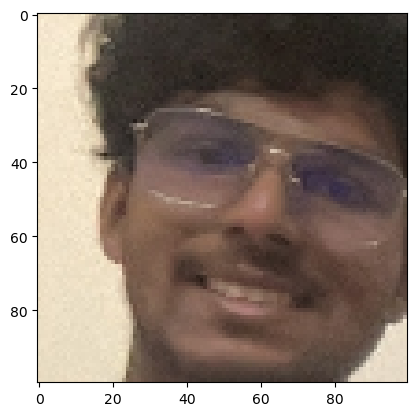

In [29]:
plt.imshow(img)

In [30]:
dataset.map(preprocess)

NameError: name 'dataset' is not defined

***Create Labelled Dataset***

In [31]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [32]:
samples = data.as_numpy_iterator()

In [33]:
example = samples.next()

In [34]:
example

(b'data/anchor/83d42142-9919-11ef-a969-8a0f60408bc9.jpg',
 b'data/positive/42170830-991b-11ef-a969-8a0f60408bc9.jpg',
 1.0)

***Build Train and Test Partition***

In [35]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [37]:
res = preprocess_twin(*example)

In [58]:
res

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.5441176 , 0.4735294 , 0.37941176],
         [0.56078434, 0.49019608, 0.39607844],
         [0.54387254, 0.47916666, 0.38210785],
         ...,
         [0.14779411, 0.11642157, 0.10465686],
         [0.14632353, 0.11495098, 0.10318627],
         [0.14166667, 0.11029412, 0.09852941]],
 
        [[0.54362744, 0.4730392 , 0.38088235],
         [0.5644608 , 0.49387255, 0.4017157 ],
         [0.56985295, 0.49926472, 0.41151962],
         ...,
         [0.12892157, 0.09754902, 0.08578432],
         [0.16348039, 0.13284314, 0.11887255],
         [0.15784314, 0.13039216, 0.10686275]],
 
        [[0.5654412 , 0.49485293, 0.40857843],
         [0.5446078 , 0.47401962, 0.3877451 ],
         [0.49019608, 0.41960785, 0.33333334],
         ...,
         [0.14852941, 0.11715686, 0.10539216],
         [0.15      , 0.12156863, 0.10098039],
         [0.15220588, 0.1247549 , 0.10122549]],
 
        ...,
 
        [[0.6754902 , 0.60490197

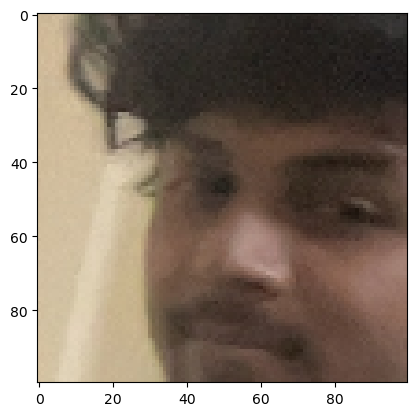

In [38]:
plt.imshow(res[1])

In [40]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [41]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [42]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

***Model Engineering***

***Build Embedding Layer***

In [43]:
inp = Input(shape=(100,100,3), name='input_image')

In [44]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [45]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [46]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [47]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [48]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [49]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [50]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [52]:
embedding = make_embedding()

In [53]:
embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

***Build Distance Layer***

In [100]:
# Siamese L1 Distance class
# Define the L1 distance layer for Siamese network
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()

    def call(self, input_embedding, validation_embedding):
        # Convert to tensors to avoid type errors
        input_embedding = tf.convert_to_tensor(input_embedding)
        validation_embedding = tf.convert_to_tensor(validation_embedding)
        return tf.math.abs(input_embedding - validation_embedding)
    
    

In [101]:
l1 = L1Dist()

In [102]:
l1

<L1Dist name=l1_dist_8, built=False>

***Make Siamese Model***

In [103]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [104]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [108]:
siamese_layer = L1Dist()
distances = siamese_layer(inp_embedding, val_embedding)

In [109]:
print(distances)

<KerasTensor shape=(1, None, 4096), dtype=float32, sparse=False, name=keras_tensor_32>


In [110]:
classifier = Dense(1, activation='sigmoid')(distances)

In [111]:
classifier

<KerasTensor shape=(1, None, 1), dtype=float32, sparse=False, name=keras_tensor_33>

In [112]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [113]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_10 (L1Dist) │ (1, None, 4096)   │          0 │ embedding[10][0], │
│                     │                   │            │ embedding[11][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

In [114]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [115]:
siamese_model = make_siamese_model()

In [116]:
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_11 (L1Dist) │ (1, None, 4096)   │          0 │ embedding[12][0], │
│                     │                   │            │ embedding[13][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

***TRAINING***

**setting up loss and optimiser**

In [117]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [118]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

**establish check points**

In [119]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

**Build Train Step Function**

In [120]:
test_batch = train_data.as_numpy_iterator()

In [121]:
batch_1 = test_batch.next()

In [122]:
X = batch_1[:2]

In [123]:
y = batch_1[2]

In [124]:
y

array([1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1.],
      dtype=float32)

In [130]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        
        # Reshape yhat to match y's shape if necessary
        yhat = tf.reshape(yhat, shape=(tf.shape(y)[0],))
        
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
        print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    # Return loss
    return loss

**Build Training Loop**

In [131]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            train_step(batch)
            progbar.update(idx+1)
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

**Train the model**

In [132]:
EPOCHS = 50

In [133]:
train(train_data, EPOCHS)


 Epoch 1/50
Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)


2024-11-04 14:59:48.269162: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Tensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
26/27 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepTensor("binary_crossentropy/Mean:0", shape=(), dtype=float32)
27/27 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step

 Epoch 2/50


2024-11-04 15:00:31.233754: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 3/50


2024-11-04 15:01:10.363872: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 4/50


2024-11-04 15:01:49.505339: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 5/50


2024-11-04 15:02:28.857192: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 6/50


2024-11-04 15:03:07.740919: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 7/50


2024-11-04 15:03:46.727648: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 8/50


2024-11-04 15:04:25.625400: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 9/50


2024-11-04 15:05:04.513807: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 237s 9s/step

 Epoch 10/50


2024-11-04 15:09:01.421905: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step


2024-11-04 15:09:40.402680: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 12/50


2024-11-04 15:10:19.938831: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 13/50


2024-11-04 15:10:58.815378: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 941s 36s/step

 Epoch 14/50


2024-11-04 15:26:39.461176: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 15/50


2024-11-04 15:27:18.315144: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 16/50


2024-11-04 15:27:57.323264: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 17/50


2024-11-04 15:28:36.233336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 18/50


2024-11-04 15:29:15.065781: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 19/50


2024-11-04 15:29:53.932023: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 20/50


2024-11-04 15:30:32.775027: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step


2024-11-04 15:31:11.629146: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 21/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 22/50


2024-11-04 15:31:51.063862: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 23/50


2024-11-04 15:32:29.933059: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 24/50


2024-11-04 15:33:08.820900: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 25/50


2024-11-04 15:33:47.722667: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 26/50


2024-11-04 15:34:26.655214: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 27/50


2024-11-04 15:35:05.541335: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 28/50


2024-11-04 15:35:44.672589: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step

 Epoch 29/50


2024-11-04 15:36:25.773923: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step

 Epoch 30/50


2024-11-04 15:37:08.469972: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step


2024-11-04 15:37:50.744322: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 31/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 502s 19s/step

 Epoch 32/50


2024-11-04 15:46:13.480204: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 33/50


2024-11-04 15:46:52.439982: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 34/50


2024-11-04 15:47:31.400066: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 35/50


2024-11-04 15:48:10.279602: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 36/50


2024-11-04 15:48:49.151934: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 37/50


2024-11-04 15:49:27.997832: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 38/50


2024-11-04 15:50:06.887161: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 39/50


2024-11-04 15:50:45.949308: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step

 Epoch 40/50


2024-11-04 15:51:37.129617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step


2024-11-04 15:53:00.247439: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence



 Epoch 41/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 53s 2s/step

 Epoch 42/50


2024-11-04 15:53:53.992627: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step

 Epoch 43/50


2024-11-04 15:54:34.084199: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 44/50


2024-11-04 15:55:12.954329: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 45/50


2024-11-04 15:55:51.812484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 46/50


2024-11-04 15:56:30.694216: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 47/50


2024-11-04 15:57:09.538123: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 48/50


2024-11-04 15:57:48.391641: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 49/50


2024-11-04 15:58:27.254838: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step

 Epoch 50/50


2024-11-04 15:59:06.115484: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


27/27 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step


2024-11-04 15:59:44.981593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


**Evaluate Model**

**Make Predictions**

In [134]:
from tensorflow.keras.metrics import Precision, Recall

In [135]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [136]:
y_hat = siamese_model.predict([test_input, test_val])
y_hat

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step


array([[[9.9998951e-01],
        [9.9997497e-01],
        [9.9999952e-01],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.5802659e-06],
        [2.1204046e-07],
        [1.8395888e-09],
        [3.6153210e-08],
        [1.0000000e+00],
        [9.9999988e-01],
        [4.1230406e-09],
        [5.7754821e-08],
        [1.0000000e+00],
        [1.0871657e-08],
        [9.9999976e-01]]], dtype=float32)

In [141]:
import numpy as np

# Convert predictions to binary values and then to a list
binary_predictions = np.where(y_hat > 0.5, 1, 0).tolist()



In [142]:
binary_predictions

[[[1],
  [1],
  [1],
  [1],
  [1],
  [0],
  [0],
  [0],
  [0],
  [1],
  [1],
  [0],
  [0],
  [1],
  [0],
  [1]]]

In [143]:
y_true


array([1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.],
      dtype=float32)

**Calculate Metrics**

In [144]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [145]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

Viz Results

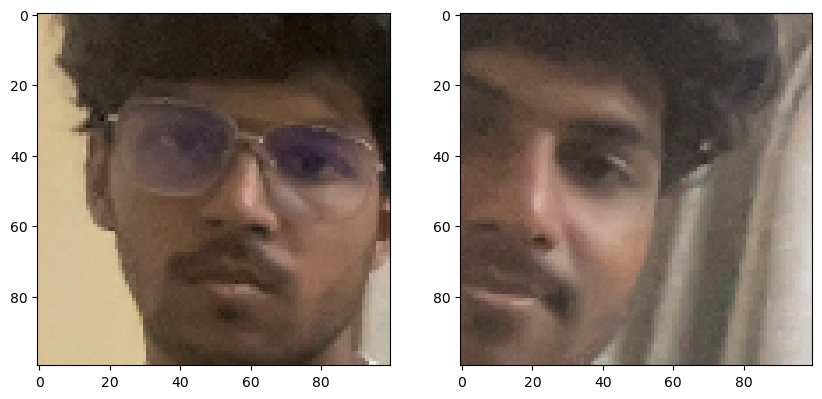

In [146]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[0])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[0])

# Renders cleanly
plt.show()

**Save Model**

In [148]:
siamese_model.save('siamesemodel.keras')

In [149]:
L1Dist

__main__.L1Dist

In [150]:
# Reload model 
model = tf.keras.models.load_model('siamesemodel.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [153]:
# Ensure the inputs are in a list or tuple format
predictions = model.predict([test_input, test_val])
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([[[9.9998951e-01],
        [9.9997497e-01],
        [9.9999952e-01],
        [1.0000000e+00],
        [1.0000000e+00],
        [1.5802659e-06],
        [2.1204046e-07],
        [1.8395888e-09],
        [3.6153210e-08],
        [1.0000000e+00],
        [9.9999988e-01],
        [4.1230406e-09],
        [5.7754821e-08],
        [1.0000000e+00],
        [1.0871657e-08],
        [9.9999976e-01]]], dtype=float32)

In [154]:
# View model summary
model.summary()# View model summary
model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_12 (L1Dist) │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_12 (L1Dist) │ (1, None, 4096)   │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (1, None, 1)      │      4,097 │ l1_dist_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

**OpenCV Real Time Verification**

In [162]:
os.listdir(os.path.join('application_data', 'verification_images'))

['88078a5e-991b-11ef-a969-8a0f60408bc9.jpg',
 'e674fd1c-9919-11ef-a969-8a0f60408bc9.jpg',
 'c3a974f2-9919-11ef-a969-8a0f60408bc9.jpg',
 '8c2148c4-991a-11ef-a969-8a0f60408bc9.jpg',
 'e2b43b84-9919-11ef-a969-8a0f60408bc9.jpg',
 '035f8d8e-991a-11ef-a969-8a0f60408bc9.jpg',
 '2e0da3d0-991b-11ef-a969-8a0f60408bc9.jpg',
 'b9130008-9919-11ef-a969-8a0f60408bc9.jpg',
 '4d273178-991b-11ef-a969-8a0f60408bc9.jpg',
 '75b88c5e-991b-11ef-a969-8a0f60408bc9.jpg',
 'cfe8407a-991b-11ef-a969-8a0f60408bc9.jpg',
 'e3e4b786-9919-11ef-a969-8a0f60408bc9.jpg',
 '438f3e26-991b-11ef-a969-8a0f60408bc9.jpg',
 'ab6ce35e-991b-11ef-a969-8a0f60408bc9.jpg',
 'c8f9bbd6-991b-11ef-a969-8a0f60408bc9.jpg',
 'c27171f0-991b-11ef-a969-8a0f60408bc9.jpg',
 '43668c02-991a-11ef-a969-8a0f60408bc9.jpg',
 'b6f1d112-991b-11ef-a969-8a0f60408bc9.jpg',
 '3851f7ca-991a-11ef-a969-8a0f60408bc9.jpg',
 'b8a20aea-991b-11ef-a969-8a0f60408bc9.jpg',
 'e3cb51f6-9919-11ef-a969-8a0f60408bc9.jpg',
 'b7e787c6-9919-11ef-a969-8a0f60408bc9.jpg',
 '027faf66

In [163]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data/input_image/input_image.jpg'

In [164]:

for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data/verification_images/88078a5e-991b-11ef-a969-8a0f60408bc9.jpg
application_data/verification_images/e674fd1c-9919-11ef-a969-8a0f60408bc9.jpg
application_data/verification_images/c3a974f2-9919-11ef-a969-8a0f60408bc9.jpg
application_data/verification_images/8c2148c4-991a-11ef-a969-8a0f60408bc9.jpg
application_data/verification_images/e2b43b84-9919-11ef-a969-8a0f60408bc9.jpg
application_data/verification_images/035f8d8e-991a-11ef-a969-8a0f60408bc9.jpg
application_data/verification_images/2e0da3d0-991b-11ef-a969-8a0f60408bc9.jpg
application_data/verification_images/b9130008-9919-11ef-a969-8a0f60408bc9.jpg
application_data/verification_images/4d273178-991b-11ef-a969-8a0f60408bc9.jpg
application_data/verification_images/75b88c5e-991b-11ef-a969-8a0f60408bc9.jpg
application_data/verification_images/cfe8407a-991b-11ef-a969-8a0f60408bc9.jpg
application_data/verification_images/e3e4b786-9919-11ef-a969-8a0f60408bc9.jpg
application_data/verification_images/438f3e26-991b-11ef-a969-8a0

In [165]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

In [170]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder 
        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

[ WARN:0@186204.681] global cap_gstreamer.cpp:1173 isPipelinePlaying OpenCV | GStreamer warning: GStreamer: pipeline have not been created


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━